**1.Import Libraries**

In [16]:
import os 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import tensorflow as tf
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

**2.Load Training Dataset**

In [17]:
data=pd.read_csv("data.csv")
data['Date']=pd.to_datetime(data['Date']).dt.date
data.set_index("Date",inplace=True)
data.head()

,Unnamed: 0,Open,High,Low,Close,Volume,MACD,RSI,ATR,MFI,CPI,USDX,IR,TB,EFFR,RMT,Score
Date,,,,,,,,,,,,,,,,,
2016-07-17,0,1718.15,1749.96,1715.14,1745.74,2272045,-37.509420,74.940143,23.122890,70.196510,112.9,107.519,8.6,0.44,0.82,51.94,0.20955
2016-07-18,1,1745.74,1786.68,1745.74,1786.59,2870497,-41.071885,82.962838,24.395540,67.197424,112.9,107.519,8.6,0.44,0.82,51.94,0.21927
2016-07-19,2,1786.59,1813.42,1785.33,1800.47,2902127,-44.502170,84.862752,24.659430,65.486818,112.9,107.519,8.6,0.44,0.82,51.94,-0.02642
2016-07-20,3,1800.47,1813.44,1782.57,1786.84,3474801,-45.595275,75.342839,25.103042,55.037084,112.9,107.519,8.6,0.44,0.82,51.94,0.15107
2016-07-21,4,1786.84,1804.75,1779.71,1798.83,3154492,-46.888559,77.863404,25.098539,67.326060,112.9,107.519,8.6,0.44,0.82,51.94,0.12900


In [18]:
output_dir_path = "E:\\Desktop\\Final Project\\results\\"

**3.Visualization of response variable**

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1500x400 with 0 Axes>

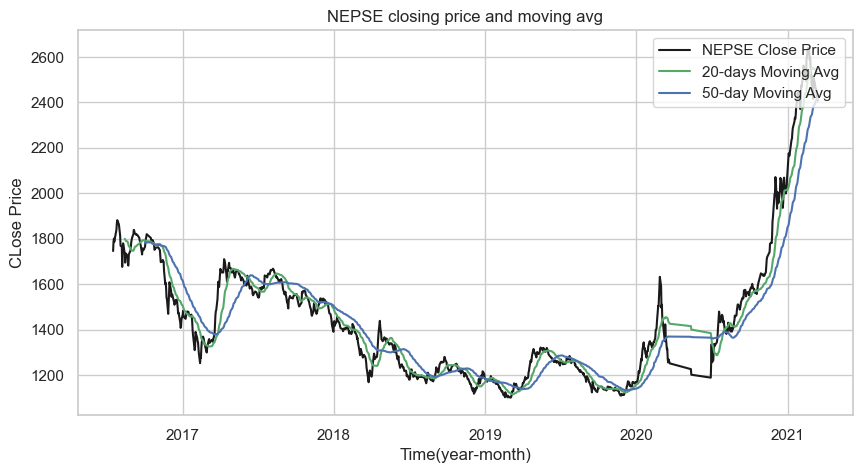

In [19]:
df=data.copy() #copy of dataframe data to df
fin=plt.figure(figsize=(15,4))
df['MA_20']=df['Close'].rolling(20).mean() #calculates 20 days moving average of the closing price cp
df['MA_50']=df['Close'].rolling(50).mean()   #calculates 50days moving avearge of cp

fig=plt.figure(figsize=(10,5))  # create new fig with size 10 inch by 5 inches
fig.set(facecolor="white")

plt.plot(df['Close'],'k',label='NEPSE Close Price')   #plots the cp in balck('k') with label Nepse
plt.plot(df['MA_20'],'g',label='20-day MA')           #plots 20 days movimng avg with green and lable as 20 days
plt.plot(df['MA_50'],'b',label='50-day MA')           #plots 50 days movimng avg with blue and lable as 20 days

plt.legend(['NEPSE Close Price','20-days Moving Avg','50-day Moving Avg'],loc='upper right')       #add legend to plot in upper right corner 
plt.title('NEPSE closing price and moving avg')  #set title of the plot
plt.xlabel('Time(year-month)')           #labels the x-axis
plt.ylabel('CLose Price')                #labels the y-axis

#specify the path where plot image will be saved
output_dir_path = "E:\\Desktop\\Final Project\\results\\"
fig.savefig(output_dir_path + 'original_data_plus_moving_averages.png', dpi=600)     #save fig as png file
plt.show

**5.Correlation Heatmap**

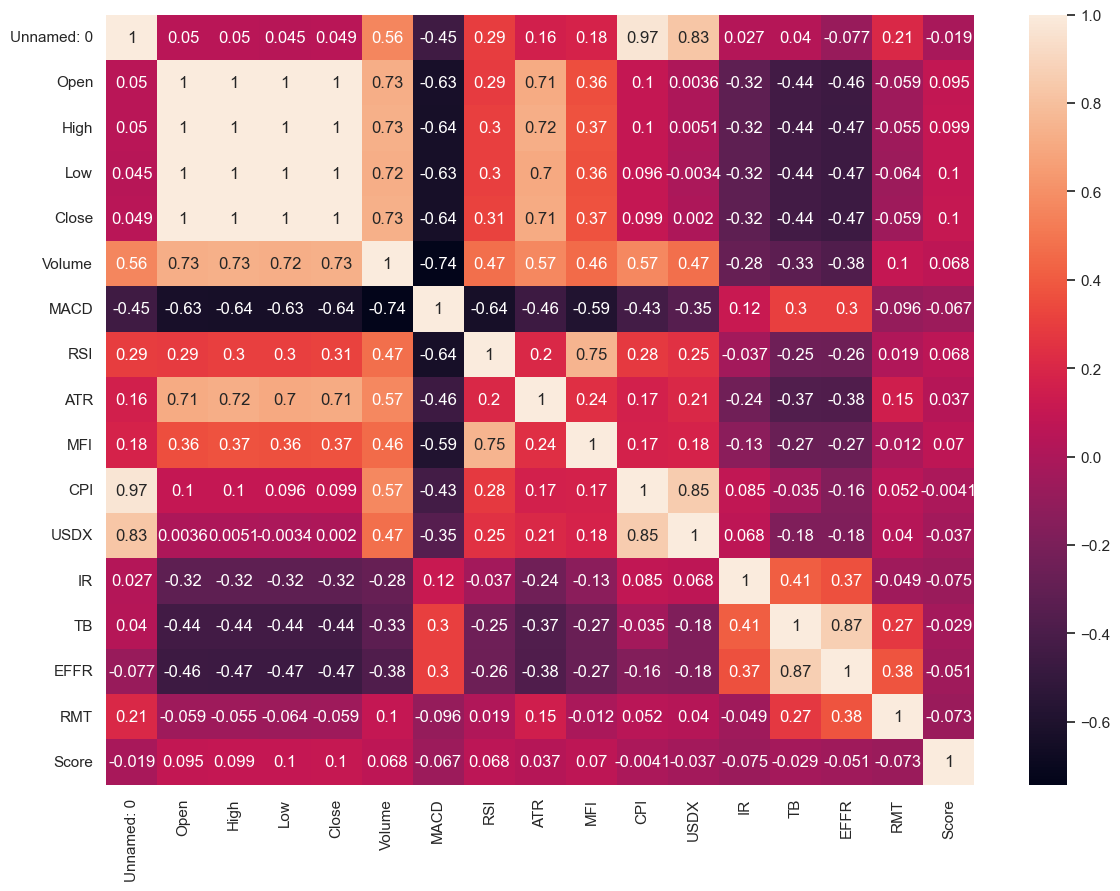

In [30]:
fig=plt.figure(figsize=(14,10))  #create new fig with size 14 inch by 10 inches

sns.heatmap(data.corr(),annot=True)   # create correlation matrix of dataframe data and create heatmap using seaborn
sns.set_style("whitegrid")   #set white background color

fig.savefig(output_dir_path+"Correlation_heatmap.pdf",dpi=600)  # save img as pdf 

**5.Machine Learning Libraries**

In [22]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Conv1D,MaxPooling2D,MaxPooling1D,Flatten
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time 
import ast
import scipy

**6.Supporting Functions**

In [23]:
def mean_absolute_percentage_error(y_true,y_pred):    #calculate mean of absolute percentage error
    return(np.mean(np.abs((y_true-y_pred)/(y_true))*100)) 

def calculate_scores(y_true,y_pred):    #calculate square root of mean square error
    rmse=math.sqrt(mean_squared_error(y_true,y_pred))

    R = np.corrcoef(y_true, y_pred)   #calculates correlation coffn matric betn true and predicted values

    mape=mean_absolute_percentage_error(y_true,y_pred) #computes the mean absolute percentage error 

    dic={'rmse':rmse,'R':R[0,1],'mape':mape}
    return (dic)

def DatasetCreation(dataset,time_step=1):
    #defining function that gives dataset
    #time step which then returns the input and output data
    DataX,DataY=[],[]
    for i in range(len(dataset)-time_setp-1):
        a=dataset[i:(I+time_setp),]
        DataX.append(a)
        DataY.append(dataset[i+time_setp,0])  #dataY contains close price
        return np.array(DataX),np.array(DataY) #convert to numpy array and return 

def data_split(data,split=0.2):   #creating 80% training and 20% testing data 
    l1=int(len(data)*(1-split))
    l2=len(data)-l1
    data1=data.iloc[0:l1,:]   #contain first l1 rows of dataset
    data2=data.iloc[1:len(data),:]    #contains remaining row from index l1 to end 
    return data1,data2

def min_max_transform(data,feature_range=(0,1)):  #scale data using min max scaling betn 0 and 1
    scaler=MinMaxScaler(feature_range)
    return scaler.fit_transform(data)

def min_max_inverse_transform(data_scaled,min_original,max_original): #reverse min-max scaling transform to original scale
    return min_original+data_scaled*(max_original-min_original)

def write_dic_to_file(dic_name,file_name):  #write content of dic to file
    file=open(file_name,'w')
    file.write(str(dic_name))
    file.close()

def read_dic_from_file(fil_name):   #read file content and convert to dictionary
    file=open(file_name,"r")
    contents=file.read()
    dictionary=ast.literal_eval(contents)
    file.close()
    return dictionary

**7.Building Deep Learning Models**

**Model 1:Build and compile LSTM Model**

In [24]:
def Build_LSTM_Model(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):
  
  model = Sequential()
    
  for i in range(len(layers)):
    if len(layers)==1:
      model.add(LSTM(int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(LSTM(int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
          
        else:
          model.add(LSTM(int(layers[i]), return_sequences=True))
          
      else:
        model.add(LSTM(int(layers[i])))
        
        
          
  model.add(Dense(1, activation = 'linear'))
  
  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adagrad': 
    opt = optimizers.Adagrad(learning_rate = learning_rate)
  elif optimizer == 'Nadam':
    opt = optimizers.Nadam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)
   
  if verbose == 1:
    print(model.summary())
  return model

**Testing**


In [25]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
time_step = 5
num_features = 10
learning_rate = 0.001
verbose = 1
layers = [50,20]

Build_LSTM_Model(layers, time_step, num_features, optimizer =  optimizers_names[0], learning_rate= learning_rate, verbose = verbose)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,901 (69.93 KB)

 Trainable params: 17,901 (69.93 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential_3, built=True>

**2.Build and compile GRU Model**

In [26]:
def Build_GRU_Model(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):
  
  model = Sequential()
    
  for i in range(len(layers)):
    if len(layers)==1:
      model.add(GRU(int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(GRU(int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
          
        else:
          model.add(GRU(int(layers[i]), return_sequences=True))
          
      else:
        model.add(GRU(int(layers[i])))
         
  model.add(Dense(1, activation = 'linear'))
  
  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adagrad': 
    opt = optimizers.Adagrad(learning_rate = learning_rate)
  elif optimizer == 'Nadam':
    opt = optimizers.Nadam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)
   
  if verbose == 1:
    print(model.summary())
  return model

**Testing**

In [27]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
time_step = 5
num_features = 9
learning_rate = 0.001
verbose = 1
layers = [50,20]

Build_GRU_Model(layers, time_step, num_features, optimizer =  optimizers_names[0], learning_rate= learning_rate, verbose = verbose)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 5, 50)          │         9,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 20)             │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,491 (52.70 KB)

 Trainable params: 13,491 (52.70 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential_4, built=True>

**3.Build and compile CNN Model**

In [28]:
def Build_CNN_Model(conv_layers,kernel_size,max_pool_size,time_step,num_features,optimizer='Adam',learning_rate=0.001,verbose=1):

  model=Sequential()

  for i in range(len(conv_layers)):
    if len(conv_layers)==1:
      model.add(Conv1D(conv_layers[i],kernel_size,activation='relu',strides=1,padding='valid',input_shape=(time_step,num_features)))  #valid means no padding 
      model.add(MaxPooling1D(max_pool_size,strides=2))
  else:
       model.add(Conv1D(conv_layers[i],kernel_size,activation='relu',strides=1,padding='valid'))
       model.add(MaxPooling1D(max_pool_size,strides=2))

  model.add(Flatten())
  model.add(Dense(20,activation='relu'))
  model.add(Dense(1,activation='linear'))     #fully connected layers 

  if optimizer=='Adam':
    opt=optimizers.Adam(learning_rate=learning_rate)
  elif optimizer=='Adagrad':
    opt=optimizers.Adagrad(learning_rate=learning_rate)
  elif optimizer=='Nadam':
    opt=optimizers.Nadam(learning_rate=learning_rate)
  elif optimizer=='Adadelta':
    opt=optimizers.Adadelta(learning_rate=learning_rate)
  elif optimizer=='RMSprop':
    opt=optimizers.RMSprop(learning_rate=learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error',optimizer=opt)

  if verbose==1:
     print(model.summary())
  return model     


**Testing**

In [29]:
optimisers_names=['Adam','Adagrad','Nadam']
time_step=5
num_features=9
learning_rate=0.001
verbose=1
conv_layers=[64]
kernel_size=2
max_pool_size=2

Build_CNN_Model(conv_layers,kernel_size,max_pool_size,time_step,num_features,optimizer=optimizers_names[0],learning_rate=learning_rate,verbose=verbose)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 0, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,513 (37.16 KB)

 Trainable params: 9,513 (37.16 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential_5, built=True>

**Tuning Hyper parameter of Deep Learning Models**

**1.Tunning Hyperparamater of LSTM Model**

In [ ]:
# def LSTM_Hyper_Parameter_Tuning(layers,data,time_setp,split,optimizers_names,learning_rates,batcg_sizes,epochs,num_replicates=2):
#     #---creating training and test data ---#
#  train_data,val_data=data_split(data,split)

#  num_features=train_data.shape[1]

#  min_train_max_train=train_data["Close"].min(),train_data["Close"].max()
#  min_val,max_val=val_data["Close"].min(),val_data["Close"].max()

#  train_data_scaled=min_max_transform(train_data)
#  val_data_scaled=min_max_transform(val_data)

#  X_train,y_train=DatasetCreation(train_data_scaled,time_step)
#  X_val,y_val=DatasetCreation(val_data_scaled,time_step)

#     #---dealing with time series ---#
#  best_avg_rmse=99999999999

#  collect_rmse=[]

#  all_avg_rmse=np.zeros((len(optimizers_names),len(learning_rates),len(batch_sizes)))

#  best_hyper_parameters={"model":layers,"optimizers":None,"learning_rate":none,"batch_size":None,"best_avg_rmse":None}

#  #hist_csv_file='model_history'+str(time.time())+'.csv'   

#  for opt in range(len(optimizers_names)):
#     for lr in range(len(learning_rates)):
#       for batch_size in range(len(batch_sizes)):
#         for i in range(num_replicates):
#           print("Running for"+optimizers_names[opt]+"optimizers"+str(learning_rates[lr])+"learninf_rate"
#                +str(batch_sizes[])+"batch_size and "+str(i)+"replicate"+"\n")

#           model=Build_LSTM_Model(layers,time_step,num_features,optimizers_names[opt],learning_rate=learning_rates[lr],verbose=0)

#           callback=tf.keras.callback.EarlyStopping(monitor='val_loss',patience=5)

#           history=model.fit(X_train,y_train,batch_size=batch_sizes[batch_size],epochs=epochs,validation_data=(X_val,y_val),callbacks=[callback],verbose=1)

            